In [7]:

#!/usr/bin/env python3
from __future__ import annotations

from pathlib import Path
import argparse
import importlib.util
import re

import numpy as np
import pandas as pd
from Bio import SeqIO

# IMPORTANT for Snakemake/headless environments:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns

# This script/notebook prduce different plots to visualize the proportion of reads/bases mapped by a set of query sequences,
# from a list of FASTA files.
# The script its intent is to map and visualize the validation sequences agaist the different FASTA files that were produced
# in each step of the dectontamination process

# The script needs to run in an environment with BLASTN
# The blast_utils from utils.
# seqIO from Bio

# Add barplot with number of mapped reads and proportion of mapped reads OK
# Inlcude new sequence decont filter in the analysis
# Secondary: Make another script that takes a sample of the reads and blast them to NCBI database
# Add this step to the Snakemake file
# Add the las steps of the pipeline to the Snakemake File
# Add a step to convert from FASTQ to fasta, (discarding low quality reads)
# Run the block pipeline to the different sequences
# Add pieachart with proportion of mapped bases at the end of the pipeline

# -------------------------
# Utils loading
# -------------------------

def load_blast_utils(blast_utils_path: str | None = None):
    if blast_utils_path:
        p = Path(blast_utils_path)
        if not p.exists():
            raise FileNotFoundError(f"blast_utils_path not found: {p}")
        spec = importlib.util.spec_from_file_location("blast_utils", str(p))
        mod = importlib.util.module_from_spec(spec)
        assert spec and spec.loader
        spec.loader.exec_module(mod)
        return mod

    local_utils = Path.cwd() / "utils" / "blast_utils.py"
    if local_utils.exists():
        spec = importlib.util.spec_from_file_location("blast_utils", str(local_utils))
        mod = importlib.util.module_from_spec(spec)
        assert spec and spec.loader
        spec.loader.exec_module(mod)
        return mod

    from utils import blast_utils as mod
    return mod


def slugify(s: str) -> str:
    s = s.strip()
    s = re.sub(r"[^A-Za-z0-9]+", "_", s)
    return s.strip("_") or "step"


# -------------------------
# Core logic
# -------------------------

def read_fasta_lengths(fasta_path: Path) -> dict[str, int]:
    lengths: dict[str, int] = {}
    with fasta_path.open("r") as fh:
        for rec in SeqIO.parse(fh, "fasta"):
            lengths[rec.id] = len(rec.seq)
    return lengths


def load_blast_table(tsv_path: Path, columns: list[str]) -> pd.DataFrame:
    if (not tsv_path.exists()) or tsv_path.stat().st_size == 0:
        return pd.DataFrame(columns=columns)
    return pd.read_csv(tsv_path, sep="\t", header=None, names=columns)


def compute_subject_coverage(bu, blast_df: pd.DataFrame, subject_lengths: dict[str, int], min_pident: float) -> pd.DataFrame:
    base = pd.DataFrame(
        {"sseqid": list(subject_lengths.keys()),
         "slen":  [subject_lengths[k] for k in subject_lengths.keys()]}
    )

    if blast_df.empty:
        base["coverage_fraction"] = 0.0
        return base

    if min_pident and min_pident > 0:
        blast_df = blast_df.loc[blast_df["pident"] >= float(min_pident)].copy()
        if blast_df.empty:
            base["coverage_fraction"] = 0.0
            return base

    blast_df = bu.alignment_absolute_start_end(blast_df)
    blast_df = blast_df.sort_values(["sseqid", "a.sstart", "a.send"], kind="mergesort")

    cov = (
        blast_df.groupby("sseqid", sort=False)
        .apply(lambda g: bu.total_coverage_merged(g, use="subject", inclusive=True), include_groups=False)
        .rename("coverage_fraction")
        .reset_index()
    )

    out = base.merge(cov, on="sseqid", how="left")
    out["coverage_fraction"] = out["coverage_fraction"].fillna(0.0)
    return out


def write_non_nam_fasta(subject_fasta: Path, coverage_df: pd.DataFrame, out_fasta: Path, nam_threshold: float) -> tuple[int, int, int]:
    nam_set = set(coverage_df.loc[coverage_df["coverage_fraction"] >= nam_threshold, "sseqid"])

    out_fasta.parent.mkdir(parents=True, exist_ok=True)

    total = nam = non_nam = 0
    with subject_fasta.open("r") as inp, out_fasta.open("w") as out:
        for rec in SeqIO.parse(inp, "fasta"):
            total += 1
            if rec.id in nam_set:
                nam += 1
            else:
                non_nam += 1
                out.write(f">{rec.id}\n{rec.seq}\n")

    return total, nam, non_nam


def plot_coverage_scatter(df: pd.DataFrame, title: str, save_png: Path):
    required = {"slen", "coverage_fraction"}
    if not required.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required}")

    save_png.parent.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(12, 5))
    plt.scatter(df["slen"], df["coverage_fraction"], alpha=0.6, s=10)
    plt.xlabel("Sequence length (bp)")
    plt.ylabel("Coverage fraction")
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(True, axis="y", alpha=0.3)
    plt.grid(False, axis="x")
    plt.tight_layout()
    plt.savefig(save_png, dpi=200, bbox_inches="tight")
    plt.close()


def plot_summary_barplots_seaborn(summary_df: pd.DataFrame, title: str, save_path: Path):
    sns.set_theme(style="whitegrid")

    df = summary_df.copy()
    df["non_nam_sequences"] = df["total_sequences"] - df["nam_sequences"]
    df["nam_fraction"] = np.where(df["total_sequences"] > 0, df["nam_sequences"] / df["total_sequences"], 0.0)
    df["non_nam_fraction"] = 1.0 - df["nam_fraction"]

    pal = sns.color_palette("deep")
    total_color = "#6b7280"     # neutral slate (recommended for totals)
    with_color  = pal[0]        # with NAM
    without_color = pal[1]      # without NAM

    fig, (ax_total, ax_nam, ax_stack) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Total
    sns.barplot(data=df, x="step_label", y="total_sequences", ax=ax_total, color=total_color, edgecolor="none")
    ax_total.set_ylabel("Total reads")
    ax_total.set_xlabel("")
    ax_total.grid(axis="y", alpha=0.3)
    ax_total.grid(False, axis="x")
    for cont in ax_total.containers:
        ax_total.bar_label(cont, labels=[f"{int(v):,}" for v in cont.datavalues], label_type="center", fontsize=10)

    # NAM
    sns.barplot(data=df, x="step_label", y="nam_sequences", ax=ax_nam, color=with_color, edgecolor="none")
    ax_nam.set_ylabel("Reads with NAM blocks")
    ax_nam.set_xlabel("")
    ax_nam.grid(axis="y", alpha=0.3)
    ax_nam.grid(False, axis="x")
    for cont in ax_nam.containers:
        ax_nam.bar_label(cont, labels=[f"{int(v):,}" for v in cont.datavalues], label_type="center", fontsize=10)

    # Stacked proportions
    x = np.arange(len(df))
    without_pct = (df["non_nam_fraction"].to_numpy() * 100.0)
    with_pct = (df["nam_fraction"].to_numpy() * 100.0)

    b1 = ax_stack.bar(x, without_pct, width=0.6, color=without_color, edgecolor="none", label="Without NAM blocks")
    b2 = ax_stack.bar(x, with_pct, width=0.6, bottom=without_pct, color=with_color, edgecolor="none", label="With NAM blocks")

    ax_stack.set_ylabel("Proportion (%)")
    ax_stack.set_ylim(0, 105)
    ax_stack.set_xlabel("")
    ax_stack.set_xticks(x)
    ax_stack.set_xticklabels(df["step_label"].tolist(), rotation=0)
    ax_stack.grid(axis="y", alpha=0.3)
    ax_stack.grid(False, axis="x")

    ax_stack.bar_label(b1, labels=[f"{v/100:.1%}" if v > 0 else "" for v in without_pct], label_type="center", fontsize=10)
    ax_stack.bar_label(b2, labels=[f"{v/100:.1%}" if v > 0 else "" for v in with_pct], label_type="center", fontsize=10)

    fig.suptitle(title, y=0.995)
    handles, labels = ax_stack.get_legend_handles_labels()
    fig.legend(handles, labels, title="Read type", loc="upper right")

    sns.despine(ax=ax_total, left=True, bottom=False)
    sns.despine(ax=ax_nam, left=True, bottom=False)
    sns.despine(ax=ax_stack, left=True, bottom=False)

    plt.tight_layout()
    save_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.close(fig)


def analyze_one(
    bu,
    validation_seqs: Path,
    subject_fasta: Path,
    workdir: Path,
    step_label: str,
    threads: int,
    word_size: int,
    min_pident: float,
    nam_threshold: float,
):
    workdir.mkdir(parents=True, exist_ok=True)

    db_dir = workdir / "blastdb"
    blast_tsv = workdir / "blast.blocks_vs_subject.tsv"

    # Always recompute in Snakemake runs to avoid stale reuse issues
    db_file = bu.makeblast_db(str(subject_fasta), str(db_dir), show_command=False)
    bu.blastn(
        blast_input_seqs=str(validation_seqs),
        blast_db_file=str(db_file),
        blast_output_table_tsv=str(blast_tsv),
        num_threads=int(threads),
        word_size=int(word_size),
        show_command=False,
    )

    blast_df = load_blast_table(blast_tsv, bu.default_blast_columns)
    subj_lens = read_fasta_lengths(subject_fasta)
    coverage_df = compute_subject_coverage(bu, blast_df, subj_lens, min_pident=min_pident)

    coverage_tsv = workdir / "coverage_by_subject.tsv"
    coverage_df.to_csv(coverage_tsv, sep="\t", index=False)

    non_nam_fasta = workdir / f"non_nam.{workdir.name}.fasta"
    total, nam, non_nam = write_non_nam_fasta(subject_fasta, coverage_df, non_nam_fasta, nam_threshold)

    plot_coverage_scatter(
        coverage_df,
        title=f"Coverage vs length — {step_label}",
        save_png=workdir / "coverage_scatter.png",
    )

    return {
        "step_id": workdir.name,
        "step_label": step_label,
        "subject_fasta": str(subject_fasta),
        "total_sequences": total,
        "nam_sequences": nam,
        "non_nam_sequences": non_nam,
        "nam_fraction": (nam / total) if total else 0.0,
        "blast_tsv": str(blast_tsv),
        "coverage_tsv": str(coverage_tsv),
        "non_nam_fasta": str(non_nam_fasta),
    }


def run_pipeline(
    validation_seqs: Path,
    subjects: list[Path],
    subject_labels: list[str] | None,
    out_dir: Path,
    threads: int,
    word_size: int,
    min_pident: float,
    nam_threshold: float,
    blast_utils_path: str | None,
):
    out_dir = Path(out_dir)
    validation_seqs = Path(validation_seqs)
    subjects = [Path(s) for s in subjects]

    bu = load_blast_utils(blast_utils_path)

    if subject_labels is not None and len(subject_labels) != len(subjects):
        raise ValueError("--subject_labels must have the same number of items as --subjects")

    out_dir.mkdir(parents=True, exist_ok=True)

    summaries = []
    for i, subject in enumerate(subjects, start=1):
        label = subject_labels[i-1] if subject_labels is not None else subject.stem
        step_id = f"{i:02d}_{slugify(label)}"
        workdir = out_dir / step_id

        summaries.append(
            analyze_one(
                bu=bu,
                validation_seqs=validation_seqs,
                subject_fasta=subject,
                workdir=workdir,
                step_label=label,
                threads=threads,
                word_size=word_size,
                min_pident=min_pident,
                nam_threshold=nam_threshold,
            )
        )

    summary_df = pd.DataFrame(summaries)
    summary_tsv = out_dir / "summary.tsv"
    summary_df.to_csv(summary_tsv, sep="\t", index=False)

    title = f"NAM-block summary by step (NAM threshold ≥ {nam_threshold:.2f})"
    plot_summary_barplots_seaborn(summary_df, title=title, save_path=out_dir / "summary_barplots.svg")


def parse_args():
    p = argparse.ArgumentParser(description="Compute NAM-block coverage across pipeline steps.")
    p.add_argument("--validation_seqs", required=True, type=Path)
    p.add_argument("--subjects", required=True, nargs="+", type=Path)
    p.add_argument("--subject_labels", nargs="+", default=None, help="Optional labels (same length as --subjects).")
    p.add_argument("--out_dir", required=True, type=Path)

    p.add_argument("--threads", type=int, default=8)
    p.add_argument("--word_size", type=int, default=11)
    p.add_argument("--min_pident", type=float, default=90.0)
    p.add_argument("--nam_threshold", type=float, default=0.50)

    p.add_argument("--blast_utils_path", type=str, default=None)
    return p.parse_args()


def main():
    DEV = True  # In notebooks: True. For CLI: False.

    if DEV:
        print("Developer mode activated!")

        validation_seqs = "/home/jpereira/OEs/Blocks_Namasivayam_without_p.fa"
        subjects = [
            "/home/jpereira/OEs/OE1.v2/Data/filter_sizes/toxo1.size_filtered.fasta",
            "/home/jpereira/OEs/OE1.v2/Data/decontamination/decont.fasta",
            "/home/jpereira/OEs/OE1.v2/Data/check_gc/decont.low_gc.fasta",
            "/home/jpereira/OEs/OE1.v2/Data/short_tandem_repeats/sequences_wo_str.fasta",
            "/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta",
        ]
        subject_labels = ["Input", "Decontamination", "GC filter", "STR filter", "MCL filter"]

        out_dir = "/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Visuals/continuos_coverage_dev"
        threads = 30
        word_size = 10
        min_pident = 90.0
        nam_threshold = 0.50
        blast_utils_path = None  # or "/path/to/utils/blast_utils.py"

        run_pipeline(
            validation_seqs=validation_seqs,
            subjects=subjects,
            subject_labels=subject_labels,
            out_dir=out_dir,
            threads=threads,
            word_size=word_size,
            min_pident=min_pident,
            nam_threshold=nam_threshold,
            blast_utils_path=blast_utils_path,
        )

    else:
        args = parse_args()
        run_pipeline(
            validation_seqs=args.validation_seqs,
            subjects=args.subjects,
            subject_labels=args.subject_labels,
            out_dir=args.out_dir,
            threads=args.threads,
            word_size=args.word_size,
            min_pident=args.min_pident,
            nam_threshold=args.nam_threshold,
            blast_utils_path=args.blast_utils_path,
        )


if __name__ == "__main__":
    main()


Developer mode activated!
Warning output db directory already exist: /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Visuals/continuos_coverage_dev/01_Input/blastdb


Building a new DB, current time: 02/08/2026 19:15:49
New DB name:   /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Visuals/continuos_coverage_dev/01_Input/blastdb/toxo1.size_filtered.fasta
New DB title:  /home/jpereira/OEs/OE1.v2/Data/filter_sizes/toxo1.size_filtered.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Visuals/continuos_coverage_dev/01_Input/blastdb/toxo1.size_filtered.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 128876 sequences in 8.78825 seconds.


makeblastdb ran successfully.
blastn ran successfully.
Warning output db directory already exist: /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Visuals/continuos_coverage_dev/02_Decontamination/blastdb


Building a new DB, current time: 02/08/2026 19:16:08

In [ ]:
from __future__ import annotations

from pathlib import Path
import sys
import argparse
import importlib.util
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt

# This script/notebook prduce different plots to visualize the proportion of reads/bases mapped by a set of query sequences,
# from a list of FASTA files.
# The script its intent is to map and visualize the validation sequences agaist the different FASTA files that were produced
# in each step of the dectontamination process

# The script needs to run in an environment with BLASTN
# The blast_utils from utils.
# seqIO from Bio

# Add barplot with number of mapped reads and proportion of mapped reads OK
# Inlcude new sequence decont filter in the analysis
# Secondary: Make another script that takes a sample of the reads and blast them to NCBI database
# Add this step to the Snakemake file
# Add the las steps of the pipeline to the Snakemake File
# Add a step to convert from FASTQ to fasta, (discarding low quality reads)
# Run the block pipeline to the different sequences
# Add pieachart with proportion of mapped bases at the end of the pipeline

# =========================
# Helpers
# =========================

def load_blast_utils(blast_utils_path: str | None = None):
    """
    Load blast_utils either from:
      1) an explicit file path (--blast_utils_path), or
      2) utils/blast_utils.py relative to current working dir, or
      3) a normal import (utils.blast_utils)
    """
    if blast_utils_path:
        p = Path(blast_utils_path)
        if not p.exists():
            raise FileNotFoundError(f"blast_utils_path not found: {p}")
        spec = importlib.util.spec_from_file_location("blast_utils", str(p))
        mod = importlib.util.module_from_spec(spec)
        assert spec and spec.loader
        spec.loader.exec_module(mod)
        return mod

    # Try "utils/blast_utils.py" in CWD (common in notebooks)
    local_utils = Path.cwd() / "utils" / "blast_utils.py"
    if local_utils.exists():
        spec = importlib.util.spec_from_file_location("blast_utils", str(local_utils))
        mod = importlib.util.module_from_spec(spec)
        assert spec and spec.loader
        spec.loader.exec_module(mod)
        return mod

    # Try normal import if utils is on PYTHONPATH
    from utils import blast_utils as mod
    return mod


def read_fasta_lengths(fasta_path: Path) -> dict[str, int]:
    lengths: dict[str, int] = {}
    with fasta_path.open("r") as fh:
        for rec in SeqIO.parse(fh, "fasta"):
            lengths[rec.id] = len(rec.seq)
    return lengths


def load_blast_table(tsv_path: Path, columns: list[str]) -> pd.DataFrame:
    if (not tsv_path.exists()) or tsv_path.stat().st_size == 0:
        return pd.DataFrame(columns=columns)
    return pd.read_csv(tsv_path, sep="\t", header=None, names=columns)


def compute_subject_coverage(
    bu,
    blast_df: pd.DataFrame,
    subject_lengths: dict[str, int],
    min_pident: float = 0.0,
) -> pd.DataFrame:
    """
    Returns one row per subject sequence, including unmapped subjects (coverage=0).
    Columns: sseqid, slen, coverage_fraction
    """
    base = pd.DataFrame(
        {"sseqid": list(subject_lengths.keys()),
         "slen":  [subject_lengths[k] for k in subject_lengths.keys()]}
    )

    if blast_df.empty:
        base["coverage_fraction"] = 0.0
        return base

    if min_pident and min_pident > 0:
        blast_df = blast_df.loc[blast_df["pident"] >= float(min_pident)].copy()
        if blast_df.empty:
            base["coverage_fraction"] = 0.0
            return base

    blast_df = bu.alignment_absolute_start_end(blast_df)
    blast_df = blast_df.sort_values(["sseqid", "a.sstart", "a.send"], kind="mergesort")

    cov = (
        blast_df.groupby("sseqid", sort=False)
        .apply(lambda g: bu.total_coverage_merged(g, use="subject", inclusive=True), 
               include_groups=False)
        .rename("coverage_fraction")
        .reset_index()
    )

    out = base.merge(cov, on="sseqid", how="left")
    out["coverage_fraction"] = out["coverage_fraction"].fillna(0.0)
    return out


def write_non_nam_fasta(
    subject_fasta: Path,
    coverage_df: pd.DataFrame,
    out_fasta: Path,
    nam_threshold: float,
) -> tuple[int, int, int]:
    """
    Writes sequences with coverage < nam_threshold to out_fasta.
    Returns: (total, nam, non_nam)
    """
    nam_set = set(coverage_df.loc[coverage_df["coverage_fraction"] >= nam_threshold, "sseqid"])

    out_fasta.parent.mkdir(parents=True, exist_ok=True)

    total = 0
    nam = 0
    non_nam = 0

    with subject_fasta.open("r") as inp, out_fasta.open("w") as out:
        for rec in SeqIO.parse(inp, "fasta"):
            total += 1
            if rec.id in nam_set:
                nam += 1
            else:
                non_nam += 1
                out.write(f">{rec.id}\n{rec.seq}\n")

    return total, nam, non_nam


def plot_coverage_scatter(df: pd.DataFrame, title: str, save_png: Path | None = None, plt_show: bool = False):
    required = {"slen", "coverage_fraction"}
    if not required.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required}")

    
    plt.figure(figsize=(14, 6))
    plt.scatter(df["slen"], df["coverage_fraction"], alpha=0.6, s=10)
    plt.xlabel("Sequence length (bp)")
    plt.ylabel("Coverage fraction")
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(True)
    if save_png is not None:
        save_png.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_png, dpi=200, bbox_inches="tight")
    
    plt.show() if plt_show else plt.close()


def analyze_one(
    bu,
    blocks_fasta: Path,
    subject_fasta: Path,
    out_dir: Path,
    threads: int,
    word_size: int,
    min_pident: float,
    nam_threshold: float,
    reuse_blast: bool,
    save_plot: bool
) -> dict:
    step = subject_fasta.stem
    db_dir = out_dir / "blastdb"
    blast_tsv = out_dir / "blast.blocks_vs_subject.tsv"

    # Run BLAST unless we are reusing cached output
    if (not reuse_blast) or (not blast_tsv.exists()) or blast_tsv.stat().st_size == 0:
        db_file = bu.makeblast_db(str(subject_fasta), str(db_dir), show_command=True)
        bu.blastn(
            blast_input_seqs=str(blocks_fasta),
            blast_db_file=str(db_file),
            blast_output_table_tsv=str(blast_tsv),
            num_threads=int(threads),
            word_size=int(word_size),
            show_command=True,
        )

    blast_df = load_blast_table(blast_tsv, bu.default_blast_columns)

    subj_lens = read_fasta_lengths(subject_fasta)
    coverage_df = compute_subject_coverage(bu, blast_df, subj_lens, min_pident=min_pident)

    coverage_tsv = out_dir / "coverage_by_subject.tsv"
    coverage_df.to_csv(coverage_tsv, sep="\t", index=False)

    non_nam_fasta = out_dir / "non_nam" / f"non_nam.{step}.fasta"
    total, nam, non_nam = write_non_nam_fasta(subject_fasta, coverage_df, non_nam_fasta, nam_threshold)

    plot_coverage_scatter(
        coverage_df,
        title=f"Coverage vs length — {step}",
        save_png=out_dir / "coverage_scatter.png" if save_plot else None,
    )

    return {
        "step": step,
        "subject_fasta": str(subject_fasta),
        "total_sequences": total,
        "nam_sequences": nam,
        "non_nam_sequences": non_nam,
        "nam_fraction": (nam / total) if total else 0.0,
        "median_slen": float(coverage_df["slen"].median()) if len(coverage_df) else 0.0,
        "mean_slen": float(coverage_df["slen"].mean()) if len(coverage_df) else 0.0,
        "median_cov": float(coverage_df["coverage_fraction"].median()) if len(coverage_df) else 0.0,
        "mean_cov": float(coverage_df["coverage_fraction"].mean()) if len(coverage_df) else 0.0,
        "blast_tsv": str(blast_tsv),
        "coverage_tsv": str(coverage_tsv),
        "non_nam_fasta": str(non_nam_fasta),
    }


def parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser(description="Compute subject coverage of block queries using BLASTN.")
    p.add_argument("--blocks_fasta", required=True, type=Path, help="FASTA with query blocks")
    p.add_argument("--subjects", required=True, nargs="+", type=Path, help="One or more subject FASTA files")
    p.add_argument("--out_dir", required=True, type=Path, help="Base output directory")

    p.add_argument("--threads", type=int, default=8)
    p.add_argument("--word_size", type=int, default=11)
    p.add_argument("--min_pident", type=float, default=90.0, help="Filter hits by pident after BLAST")
    p.add_argument("--nam_threshold", type=float, default=0.50, help="Coverage >= threshold => NAM")
    p.add_argument("--reuse_blast", action="store_true", help="Reuse cached BLAST output if present")
    p.add_argument("--save_plot", action="store_true", help="Save PNG plots")

    p.add_argument("--blast_utils_path", type=str, default=None,
                   help="Optional explicit path to blast_utils.py")

    return p.parse_args()


def run_pipeline(
    blocks_fasta: str | Path,
    subjects: list[str | Path],
    out_dir: str | Path,
    threads: int = 8,
    word_size: int = 11,
    min_pident: float = 90.0,
    nam_threshold: float = 0.50,
    reuse_blast: bool = True,
    save_plot: bool = False,
    blast_utils_path: str | None = None,
):
    bu = load_blast_utils(blast_utils_path)

    blocks_fasta = Path(blocks_fasta)
    out_dir = Path(out_dir)
    subjects = [Path(s) for s in subjects]

    out_dir.mkdir(parents=True, exist_ok=True)

    summaries: list[dict] = []
    for subject in subjects:
        step = subject.stem
        workdir = out_dir / step
        workdir.mkdir(parents=True, exist_ok=True)
        summaries.append(
            analyze_one(
                bu=bu,
                blocks_fasta=blocks_fasta,
                subject_fasta=subject,
                out_dir=workdir,
                threads=threads,
                word_size=word_size,
                min_pident=min_pident,
                nam_threshold=nam_threshold,
                reuse_blast=reuse_blast,
                save_plot=save_plot,
            )
        )

    summary_df = pd.DataFrame(summaries)
    summary_tsv = out_dir / "summary.tsv"
    summary_df.to_csv(summary_tsv, sep="\t", index=False)

    print("\nSaved:", summary_tsv)
    print(summary_df[["step", "total_sequences", "nam_sequences", "nam_fraction"]].to_string(index=False))

    return summary_df


# =========================
# Option B: DEV vs argparse
# =========================

DEV = True  # <-- In a notebook, keep this True. In a .py script for CLI use, set False.

if DEV:
    print("Developer mode activated!")

    blocks_fasta = "/home/jpereira/OEs/Blocks_Namasivayam_without_p.fa"
    subjects = [
        "/home/jpereira/OEs/OE1.v2/Data/filter_sizes/toxo1.size_filtered.fasta",
        "/home/jpereira/OEs/OE1.v2/Data/decontamination/decont.fasta",
        "/home/jpereira/OEs/OE1.v2/Data/check_gc/decont.low_gc.fasta",
        "/home/jpereira/OEs/OE1.v2/Data/short_tandem_repeats/sequences_wo_str.fasta",
        "/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta",
    ]

    out_dir = "/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Visuals/continuos_coverage_dev"

    threads = 30
    word_size = 10
    min_pident = 90.0
    nam_threshold = 0.50
    reuse_blast = True
    save_plot = True

    # If your blast_utils.py is not in ./utils/, set it explicitly:
    # blast_utils_path = "/mnt/data/blast_utils.py"
    blast_utils_path = None

    summary_df = run_pipeline(
        blocks_fasta=blocks_fasta,
        subjects=subjects,
        out_dir=out_dir,
        threads=threads,
        word_size=word_size,
        min_pident=min_pident,
        nam_threshold=nam_threshold,
        reuse_blast=reuse_blast,
        save_plot=save_plot,
        blast_utils_path=blast_utils_path,
    )

else:
    # CLI mode (argparse)
    args = parse_args()
    summary_df = run_pipeline(
        blocks_fasta=args.validation_seqs,
        subjects=args.subjects,
        out_dir=args.out_dir,
        threads=args.threads,
        word_size=args.word_size,
        min_pident=args.min_pident,
        nam_threshold=args.nam_threshold,
        reuse_blast=args.reuse_blast,
        save_plot=args.save_plot,
        blast_utils_path=args.blast_utils_path,
    )




Developer mode activated!

Saved: /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Visuals/continuos_coverage_dev/summary.tsv
               step  total_sequences  nam_sequences  nam_fraction
toxo1.size_filtered           128876           1332      0.010336
             decont            12567            631      0.050211
      decont.low_gc             1678            631      0.376043
   sequences_wo_str              910            625      0.686813
          cluster_1              625            625      1.000000


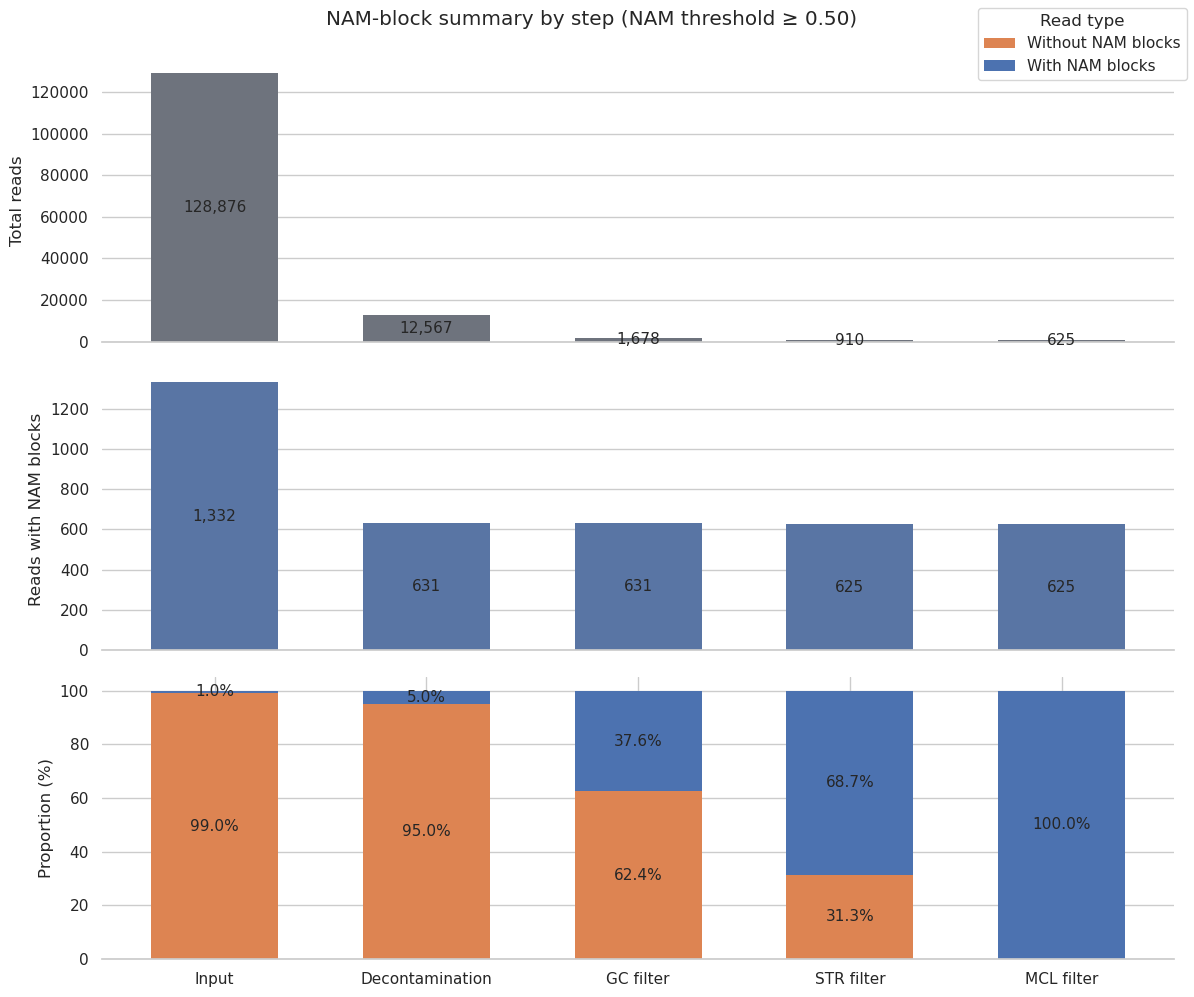

In [14]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_summary_barplots(
    summary_df: pd.DataFrame,
    *,
    step_order: list[str] | None = None,
    step_labels: dict[str, str] | None = None,
    nam_threshold: float | None = None,
    title: str | None = None,
    save_path: str | Path | None = None,
    show: bool = True,
    figsize: tuple[float, float] = (12, 10),
    palette_name: str = "deep",
    color_idx_total: int = 0,
    color_idx_nam: int = 0,
    color_idx_non_nam: int = 1,
    despine: bool = True,
):
    """
    3-panel figure (Seaborn style):
      (1) Total reads per step
      (2) Reads with NAM blocks per step
      (3) Stacked bar plot: % with NAM vs % without NAM per step

    Required columns in summary_df:
      - step
      - total_sequences
      - nam_sequences
    """
    sns.set_theme(style="whitegrid")

    required = {"step", "total_sequences", "nam_sequences"}
    missing = required - set(summary_df.columns)
    if missing:
        raise ValueError(f"summary_df is missing required columns: {sorted(missing)}")

    df = summary_df.copy()
    df["non_nam_sequences"] = df["total_sequences"] - df["nam_sequences"]
    df["nam_fraction"] = np.where(df["total_sequences"] > 0, df["nam_sequences"] / df["total_sequences"], 0.0)
    df["non_nam_fraction"] = 1.0 - df["nam_fraction"]

    # Step ordering
    if step_order is not None:
        present = set(df["step"].astype(str))
        ordered = [s for s in step_order if s in present]
        df["step"] = pd.Categorical(df["step"].astype(str), categories=ordered, ordered=True)
        df = df.sort_values("step")
    else:
        df["step"] = df["step"].astype(str)
        df = df.sort_values("step")

    # Pretty labels (optional)
    if step_labels:
        df["step_label"] = df["step"].astype(str).map(lambda s: step_labels.get(s, s))
    else:
        df["step_label"] = df["step"].astype(str)

    # Colors (match your idea)
    pal = sns.color_palette(palette_name)
    c_total = "#6b7280" #pal[color_idx_total]
    c_nam = pal[color_idx_nam]
    c_without = pal[color_idx_non_nam]
    c_with = pal[color_idx_nam]

    # --- Build figure ---
    fig, (ax_total, ax_nam, ax_stack) = plt.subplots(3, 1, figsize=figsize, sharex=True)

    # (1) Total reads
    sns.barplot(
        data=df,
        x="step_label",
        y="total_sequences",
        ax=ax_total,
        color=c_total,
        edgecolor="none",
        width=0.6,
    )
    ax_total.set_ylabel("Total reads")
    ax_total.set_xlabel("")
    ax_nam.grid(axis="x", visible=False)
    # Labels inside bars
    for cont in ax_total.containers:
        ax_total.bar_label(
            cont,
            labels=[f"{int(v):,}" for v in cont.datavalues],
            label_type="center",
            fontsize=11,
        )

    # (2) NAM reads
    sns.barplot(
        data=df,
        x="step_label",
        y="nam_sequences",
        ax=ax_nam,
        color=c_nam,
        edgecolor="none",
        width=0.6,
    )
    ax_nam.set_ylabel("Reads with NAM blocks")
    ax_nam.set_xlabel("")
    ax_nam.grid(axis="x", visible=False)
    for cont in ax_nam.containers:
        ax_nam.bar_label(
            cont,
            labels=[f"{int(v):,}" for v in cont.datavalues],
            label_type="center",
            fontsize=11,
        )

    # (3) Stacked proportions (%)
    # Seaborn doesn't natively stack, so we do stacking with matplotlib but keep seaborn styling + palette.
    x = np.arange(len(df))
    without_pct = (df["non_nam_fraction"].to_numpy() * 100.0)
    with_pct = (df["nam_fraction"].to_numpy() * 100.0)

    b1 = ax_stack.bar(x, without_pct, width=0.6, color=c_without, edgecolor="none", label="Without NAM blocks")
    b2 = ax_stack.bar(x, with_pct, width=0.6, bottom=without_pct, color=c_with, edgecolor="none", label="With NAM blocks")

    ax_stack.set_ylabel("Proportion (%)")
    ax_stack.set_ylim(0, 105)
    ax_stack.set_xlabel("")
    ax_stack.set_xticks(x)
    ax_stack.set_xticklabels(df["step_label"].tolist(), rotation=0)
    ax_nam.grid(axis="x", visible=False)

    # Percentage labels centered in each stack segment
    ax_stack.bar_label(
        b1,
        labels=[f"{v/100:.1%}" if v > 0 else "" for v in without_pct],
        label_type="center",
        fontsize=11,
    )
    ax_stack.bar_label(
        b2,
        labels=[f"{v/100:.1%}" if v > 0 else "" for v in with_pct],
        label_type="center",
        fontsize=11,
    )

    # Title + legend
    if title is None:
        title = "NAM-block summary by step"
    if nam_threshold is not None:
        title = f"{title} (NAM threshold ≥ {nam_threshold:.2f})"
    fig.suptitle(title, y=0.995)

    # Put one legend for the stacked plot (upper right like your example)
    handles, labels = ax_stack.get_legend_handles_labels()
    fig.legend(handles, labels, title="Read type", loc="upper right")

    if despine:
        sns.despine(ax=ax_total, left=True, bottom=False)
        sns.despine(ax=ax_nam, left=True, bottom=False)
        sns.despine(ax=ax_stack, left=True, bottom=False)

    plt.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=200, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, (ax_total, ax_nam, ax_stack)


step_order = ["toxo1.size_filtered", "decont", "decont.low_gc", "sequences_wo_str", "cluster_1"]

step_labels = {
    "toxo1.size_filtered": "Input",
    "decont": "Decontamination",
    "decont.low_gc": "GC filter",
    "sequences_wo_str": "STR filter",
    "cluster_1": "MCL filter",
}

fig, axes = plot_summary_barplots(
    summary_df,
    step_order=step_order,
    step_labels=step_labels,
    nam_threshold=0.50,
    save_path="/home/jpereira/OEs/OE1.v2/Data/continuos_coverage_dev/summary_barplots.svg",
    show=True,
)
